# Part 0: Preprocessing

In [1]:
# Import modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random

In [2]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

# Set model directory

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'Model')

# set embedding directory
embedding_dir = 'Z:\\Jupyter\\Embeddings'

In [4]:
# Set data paths

train_path = os.path.join(data_dir, 'train.csv')

train_processed_path = os.path.join(data_dir, 'interim', 'train_preprocessed.txt')

meta_feat_path = os.path.join(data_dir, 'interim', 'meta_feat.txt')

In [5]:
train = pd.read_csv(train_path)
train_processed = pd.read_json(train_processed_path).sort_index()
meta_feat = pd.read_json(meta_feat_path).sort_index()

In [6]:
train_processed.head()

,text,drug,sentiment
0,autoimmune disease tend come cluster gilenya –...,gilenya,2
1,completely understand would want try it but re...,gilenya,2
2,interest target s1p-1 receptor rather 1-5 like...,fingolimod,2
3,interesting grand merci wonder lemtrada ocrevu...,ocrevus,2
4,hi everybody late mri result brain cervical co...,gilenya,1


In [7]:
meta_feat.head()

,sentiment,n_upper,word_count,char_count,avg_wlen,adj_drug_count,n_stop,n_num,drug_category
0,2,1,76,404,5.315789,0.026316,28,0,38
1,2,5,206,1184,5.747573,0.000000,85,0,38
2,2,4,135,780,5.777778,0.007407,50,3,35
3,2,1,20,124,6.200000,0.100000,5,0,64
4,1,8,115,612,5.321739,0.000000,44,0,38


# Part 1: Machine Learning

In [8]:
# Import Naive Bayes

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from custom_function.ml import create_classifier, evaluate_classifier, get_model_results
import pickle

# <font color='Blue'>Baseline Model</font>

# Define X and y

X = meta_feat.drop("sentiment", axis = 1)
y = meta_feat.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

%%time

filename = 'baseline_lr.sav'

parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = StandardScaler())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

unique, counts = np.unique(clf.predict(Xtest), return_counts=True)
dict(zip(unique, counts))

# <font color='Blue'>Bag of Word models</font>

In [9]:
# Define X and y

X = train_processed.text
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

## <font color='green'>Naive Bayes - BoW</font>

%%time

filename = 'nb_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha':[0.01, 0.1, 1, 10]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## <font color='green'>Naive Bayes - Tfidf</font>

%%time

filename = 'nb_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha':[0.01, 0.1, 1, 10]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>Random Forest - BoW</font>

%%time

filename = 'rf_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
              'pre__ngram_range':[(1,1),(1,2)],
              'model__n_estimators':[10 , 20, 40],
              'model__max_features': ['auto', 'sqrt', 'log2']}

clf = create_classifier(Xtrain,
                        ytrain,
                        RandomForestClassifier(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>Random Forest - TfIdf</font>

%%time

filename = 'rf_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
              'pre__ngram_range':[(1,1),(1,2)],
              'model__n_estimators':[10 , 20, 40],
              'model__max_features': ['auto', 'sqrt', 'log2']}

clf = create_classifier(Xtrain,
                        ytrain,
                        RandomForestClassifier(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>SVC - BoW</font>

%%time

filename = 'svc_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
              'model__C':[0.01, 0.1, 1],
              'model__kernel':['linear', 'poly', 'rbf'],
              'model__gamma':['auto', 'scale']}

clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(probability = True),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>SVC - TfIdf</font>

%%time

filename = 'svc_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
              'model__C':[0.01, 0.1, 1],
              'model__kernel':['linear', 'poly', 'rbf'],
              'model__gamma':['auto', 'scale']}

clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>Logistic Regression - BoW</font>

%%time

filename = 'lr_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>Logistic Regression - TfIdf</font>

%%time

filename = 'lr_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>SGD - BoW</font>

%%time

filename = 'sgd_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(max_iter = 1000, loss = 'log', penalty = 'l2'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

##  <font color='green'>SGD - TfIdf</font>

%%time

filename = 'sgd_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(max_iter = 1000, loss = 'log', penalty = 'l2'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

In [10]:
models = ['nb_bow.sav', 'nb_tfidf.sav', 
          'rf_bow.sav', 'rf_tfidf.sav', 
          'svc_bow.sav', 'svc_tfidf.sav', 
          'lr_bow.sav', 'lr_tfidf.sav',
          'sgd_bow.sav', 'sgd_tfidf.sav']

results = get_model_results(models, model_dir, Xtest, ytest)
results.sort_values("f1_macro", ascending = False)

,model,f1_macro
7,lr_tfidf.sav,0.505540
6,lr_bow.sav,0.489985
4,svc_bow.sav,0.483195
0,nb_bow.sav,0.472725
1,nb_tfidf.sav,0.454624
8,sgd_bow.sav,0.442978
9,sgd_tfidf.sav,0.398064
2,rf_bow.sav,0.392240
3,rf_tfidf.sav,0.372747
5,svc_tfidf.sav,0.349863


<div class="alert alert-block alert-info">
<b>Conclusion:</b> Out of all the algorithms, Logistic Regression, especially the tfidf version, seem to pull ahead in terms of cross validation score. This is an expected result as logistic regression is a simple parametric approach that adds weights and not prone to overfitting on small dataset. On the other hand, tree-based algorithms performed the worst due to the small number of samples and its tendency to overfit in sparse data (it's advantages are finding non-linear patterns). Support Vector works very well on sparse data, thus, it performs better with the bag of word approach instead of the tdidf approach. Naive Bayes performs relatively well with text data, but it's not our favorite.  
</div>

# <font color='Blue'>Emsemble model</font>

## <font color='green'>Averaging Best models</font>

def get_label(row):
    """
    Get regular label from one hot encoded labels
    """
    for label in [0,1,2]:
        if row[label] == 1:
            return label

filename = "lr_tfidf.sav"
pred_lr_tfidf = pickle.load(open(os.path.join(model_dir, filename), 'rb')).predict_proba(Xtest)
filename = "nb_bow.sav"
pred_nb_bow = pickle.load(open(os.path.join(model_dir, filename), 'rb')).predict_proba(Xtest)
filename = "svc_bow.sav"
pred_svc_bow = pickle.load(open(os.path.join(model_dir, filename), 'rb')).predict_proba(Xtest)

final_pred = pd.DataFrame((pred_lr_tfidf + pred_nb_bow + pred_svc_bow)/3)

ypred_max = final_pred.apply(max, axis = 1)
for index, row in final_pred.iterrows():
    for label, item in row.items():
        if item == ypred_max[index]:
            row[label] = 1
        else:
            row[label] = 0
final_pred = final_pred.apply(get_label, axis = 1)

print(f1_score(ytest, final_pred, average = 'macro'))

## <font color='green'>Stacking Meta and BoW Features</font>

In [11]:
# Vectorizing the sparse features

vec = TfidfVectorizer(min_df = 15, ngram_range=(1, 2))
#vec_fit = vec.fit(train_processed.text)
sparse_feat = vec.fit_transform(train_processed.text)
sparse_feat

# Scaling meta features

scaler = MinMaxScaler()
meta_feat_scaled = scaler.fit_transform(meta_feat.drop("sentiment", axis = 1))

# Combine the features

from scipy.sparse import coo_matrix, hstack

meta_feat_scaled = coo_matrix(meta_feat_scaled)
meta_feat_scaled

# Derive X and Y

X = hstack([sparse_feat, meta_feat_scaled.astype(float)])
y = train_processed.sentiment
indices = train_processed.index

# Derive train/test set

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

## <font color='green'>Logistic Regression on stacked Features</font>

filename = 'lr_stacked.sav'


parameter = {'model__C':[0.01, 0.1, 1, 10, 100, 1000]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## <font color='green'>Naive Bayes on stacked Features</font>

filename = 'nb_stacked.sav'

parameter = {'model__alpha':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## <font color='green'>SVC on stacked Features</font>

filename = 'svc_stacked.sav'

parameter = {'model__C':[0.01, 0.1, 1],
             'model__kernel':['linear', 'poly', 'rbf'],
             'model__gamma':['auto', 'scale']}


clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## <font color='green'>SGD on stacked Features</font>

filename = 'sgd_stacked.sav'

parameter = {'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}


clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

In [12]:
models = ['nb_stacked.sav', 'lr_stacked.sav', 'svc_stacked.sav', 'sgd_stacked.sav']
results = get_model_results(models, model_dir, Xtest, ytest)
results.sort_values("f1_macro", ascending = False)

,model,f1_macro
1,lr_stacked.sav,0.524992
3,sgd_stacked.sav,0.459783
0,nb_stacked.sav,0.444112
2,svc_stacked.sav,0.359722


<div class="alert alert-block alert-info">
<b>Conclusion:</b>  Using average concensus of the three best model didn't really give a better prediction. However, stacking the model with the meta data extracted in our pre-processing step seems to have given the model a little bit more information and improved our score marginally
</div>

## <font color='green'>Best score analysis</font>

In [13]:
filename = 'lr_stacked.sav'

clf = pickle.load(open(os.path.join(model_dir, filename), 'rb'))

f1macro_score, cm = evaluate_classifier(clf, Xtest, ytest)

print(f1macro_score) 
print(cm) 
print(clf.best_params_)

0.5249915459109077
[[ 50  20  41]
 [ 17  94  64]
 [103 125 542]]
{'model__C': 1}


In [14]:
print("Precision for positive sentiment is %.2f, Recall for positive sentiment is %.2f" % 
      (precision_score(ytest, clf.predict(Xtest), labels = [0], average = 'macro'),
      recall_score(ytest, clf.predict(Xtest), labels = [0], average = 'macro')))
print("Precision for negative sentiment is %.2f, Recall for negative sentiment is %.2f" % 
      (precision_score(ytest, clf.predict(Xtest), labels = [1], average = 'macro'),
      recall_score(ytest, clf.predict(Xtest), labels = [1], average = 'macro')))
print("Precision for neutral sentiment is %.2f, Recall for neutral sentiment is %.2f" % 
      (precision_score(ytest, clf.predict(Xtest), labels = [2], average = 'macro'),
      recall_score(ytest, clf.predict(Xtest), labels = [2], average = 'macro')))

Precision for positive sentiment is 0.29, Recall for positive sentiment is 0.45
Precision for negative sentiment is 0.39, Recall for negative sentiment is 0.54
Precision for neutral sentiment is 0.84, Recall for neutral sentiment is 0.70


## <font color='green'>Tuning to business requirement</font>

In [15]:
for index, item in ytrain.iteritems():
    if item == 2:
        ytrain[index] = 0

In [16]:
for index, item in ytest.iteritems():
    if item == 2:
        ytest[index] = 0

In [30]:
filename = 'lr_stacked_neg_vs_all.sav'


parameter = {'model__C':[0.01, 0.1, 1, 10, 100, 1000]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        "f1",
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1442s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished


0.6485818562707648
[[715 166]
 [ 78  97]]
{'model__C': 1}


In [31]:
print("Precision for negative sentiment is %.2f, Recall for negative sentiment is %.2f" % 
      (precision_score(ytest, clf.predict(Xtest), labels = [1]),
      recall_score(ytest, clf.predict(Xtest), labels = [1])))

Precision for negative sentiment is 0.37, Recall for negative sentiment is 0.55


from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta = 5)

In [19]:
filename = 'lr_stacked_neg_max_recall.sav'


parameter = {'model__C':[0.01, 0.1, 1, 10, 100, 1000]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        "recall",
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1809s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s


0.5654301549031799
[[579 302]
 [ 66 109]]
{'model__C': 0.01}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished


In [32]:
print("Precision for negative sentiment is %.2f, Recall for negative sentiment is %.2f" % 
      (precision_score(ytest, clf.predict(Xtest), labels = [1]),
      recall_score(ytest, clf.predict(Xtest), labels = [1])))

Precision for negative sentiment is 0.37, Recall for negative sentiment is 0.55


In [33]:
len(ytest)

1056

# <font color='Blue'>Word Embedding models</font>

## <font color='green'>W2V Custom Trained Grid Search - Dimension</font>

In [21]:
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing

In [22]:
def get_mean_vector(word2vec_model, n_dim, doc):
    """ 
    From a document, derive the mean vector of its vocabularies with embeddings from a specified word2vec model with dimension n
    """
    
    # remove out-of-vocabulary words
    word_list = [word for word in doc if word in word2vec_model.wv.vocab]
    
    # Take average if the doc contains in-vocabulary words, else, take a matrix of zeroes
    if len(word_list) >= 1:
        return np.mean(word2vec_model[word_list], axis=0)
    else:
        return ([0] * n_dim)

%%time
#### Create Word2vec word embeddings
n_window = 4
w2v_dimension_grid = {}
for n_dim in np.arange(50,550,50):

    sentences = [row.split() for row in train_processed.text]

    cores = multiprocessing.cpu_count()

    w2v_model = Word2Vec(min_count=10,
                         window=n_window,
                         size=n_dim,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=1)

    w2v_model.build_vocab(sentences)

    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

    #### Derive word2vec features

    # Create a dictionary with the vocabs and its embeddings
    w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

    # Initialize a vector features dictionary
    vec_features = {}

    # Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
    for index, doc in train_processed.text.iteritems(): 
        vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

    # Create a document feature dataframe
    vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
    vec_features_df.shape

    #### Evaluate classifier with given word2vec embeddings

    # Define X and y

    X = vec_features_df
    y = train_processed.sentiment
    indices = train_processed.index

    # Split train and test set

    Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

    # Specify save file for model
    filename = 'lr_w2v.sav'

    # Specify parameter grid
    parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

    # Run grid search to create best classifier of type
    clf = create_classifier(Xtrain, 
                            ytrain,
                            LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                            parameter,
                            5,
                            'f1_macro',
                            open(os.path.join(model_dir,filename), 'wb'))

    # Extract classifier score
    f1macro_score, cm = evaluate_classifier(clf,
                                           Xtest,
                                           ytest)

    # Save score
    w2v_dimension_grid[n_dim] = f1macro_score

    # Print score
    print("F1-score for number of dimension: [%.d] is:[%.3f]" % (n_dim, f1macro_score))

w2v_dimension_search = pd.DataFrame.from_dict(w2v_dimension_grid, orient = 'index' )

w2v_dimension_search.to_json(os.path.join(data_dir, 'interim', 'w2v_dimension_search_results.txt'))

In [23]:
w2v_dimension_search = pd.read_json(os.path.join(data_dir, 'interim', 'w2v_dimension_search_results.txt'))

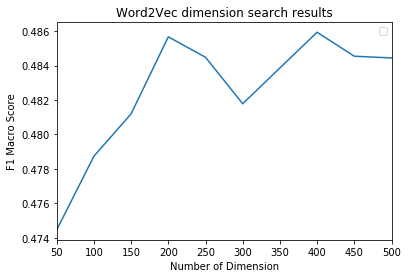

In [24]:
w2v_dimension_search.sort_index().plot()
plt.title('Word2Vec dimension search results')
plt.xlabel('Number of Dimension')
plt.ylabel('F1 Macro Score')
plt.legend('')
plt.show()

## <font color='green'>W2V Custom Trained Grid Search - Window Size</font>

%%time
#### Create Word2vec word embeddings
n_dim = 200
w2v_window_size_grid = {}
for n_window in np.arange(1,15,1):

    sentences = [row.split() for row in train_processed.text]

    cores = multiprocessing.cpu_count()

    w2v_model = Word2Vec(min_count=10,
                         window=n_window,
                         size=n_dim,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=1)

    w2v_model.build_vocab(sentences)

    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

    #### Derive word2vec features

    # Create a dictionary with the vocabs and its embeddings
    w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

    # Initialize a vector features dictionary
    vec_features = {}

    # Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
    for index, doc in train_processed.text.iteritems(): 
        vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

    # Create a document feature dataframe
    vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
    vec_features_df.shape

    #### Evaluate classifier with given word2vec embeddings

    # Define X and y

    X = vec_features_df
    y = train_processed.sentiment
    indices = train_processed.index

    # Split train and test set

    Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

    # Specify save file for model
    filename = 'lr_w2v.sav'

    # Specify parameter grid
    parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

    # Run grid search to create best classifier of type
    clf = create_classifier(Xtrain, 
                            ytrain,
                            LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                            parameter,
                            5,
                            'f1_macro',
                            open(os.path.join(model_dir,filename), 'wb'))

    # Extract classifier score
    f1macro_score, cm = evaluate_classifier(clf,
                                           Xtest,
                                           ytest)

    # Save score
    w2v_window_size_grid[n_window] = f1macro_score

    # Print score
    print("F1-score for window size: [%.d] is:[%.3f]" % (n_window, f1macro_score))

w2v_window_size_search = pd.DataFrame.from_dict(w2v_window_size_grid, orient = 'index' )

w2v_window_size_search.to_json(os.path.join(data_dir, 'interim', 'w2v_window_size_search_results.txt'))

In [25]:
w2v_window_size_search = pd.read_json(os.path.join(data_dir, 'interim', 'w2v_window_size_search_results.txt'))

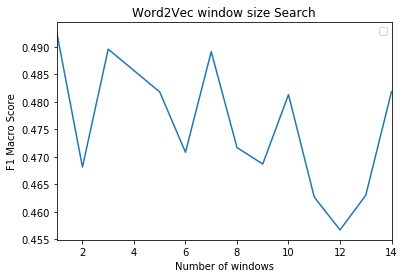

In [26]:
w2v_window_size_search.sort_index().plot()
plt.title('Word2Vec window size Search')
plt.xlabel('Number of windows')
plt.ylabel('F1 Macro Score')
plt.legend('')
plt.show()

## <font color='green'>W2V Custom Trained Grid Search - Best Param</font>

n_window = 7
n_dim = 200

sentences = [row.split() for row in train_processed.text]

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=10,
                     window=n_window,
                     size=n_dim,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

w2v_model.build_vocab(sentences)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

w2v_model.save(os.path.join(embedding_dir, 'w2v_best.bin'))

#### Derive word2vec features

# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print("F1-score for window size: [%.d] and number of dimension [%.d] is:[%.3f]" % (n_window, n_dim, f1macro_score))

# Save model score
w2v_best = f1macro_score

## <font color='green'>Best W2V With Meta Features</font>

n_window = 7
n_dim = 200

sentences = [row.split() for row in train_processed.text]

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=10,
                     window=n_window,
                     size=n_dim,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

w2v_model.build_vocab(sentences)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

#### Derive word2vec features

# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Scale Meta Features and concatenate with word embedding
# meta_feat = meta_feat.drop("sentiment", axis = 1)

# Scale meta features
scaler = StandardScaler()
meta_features = pd.DataFrame(scaler.fit_transform(meta_feat.drop("sentiment", axis = 1)), 
                             columns = meta_feat.drop("sentiment", axis = 1).columns)

# Concatenate with word embedding features
vec_features_df = pd.concat([vec_features_df, meta_features], axis = 1)

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_stacked_w2v.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print("F1-score for stacking meta features with W2V with window size [%.d] and number of dimension [%.d] is [%.3f]" % (n_window, n_dim, f1macro_score))

# Save model score
w2v_stacked_best = f1macro_score

## <font color='green'>W2V Google Pre-trained</font>

# Load Google's pre-trained Word2Vec model.

w2v_google_model = KeyedVectors.load_word2vec_format(os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin'), binary=True)

# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_google_model.wv.index2word, w2v_google_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_google_model, 300, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_pretrained_google.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

w2v_pretrained_google = f1macro_score

## <font color='green'>GloVe Stanford Pre-trained</font>

import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = os.path.join(embedding_dir, 'glove.6B.300d.txt')
word2vec_output_file = os.path.join(embedding_dir,'glove.6B.300d.txt.word2vec')
glove2word2vec(glove_input_file, word2vec_output_file)

from gensim.scripts.glove2word2vec import glove2word2vec
word2vec_output_file = os.path.join(embedding_dir,'glove.6B.300d.txt.word2vec')
w2v_glove_stanford_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_glove_stanford_model.wv.index2word, w2v_glove_stanford_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_glove_stanford_model, 300, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_pretrained_glove_stanford.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

glova_pretrained_stanford = f1macro_score

## <font color='green'>Fasttext</font>

import nltk
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for document in train_processed.text]

# Set values for various parameters
feature_size = 200    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, 
                    size=feature_size, 
                    window=window_context, 
                    min_count=min_word_count,
                    sample=sample, 
                    sg=1, 
                    iter=50)

# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(ft_model.wv.index2word, ft_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(ft_model, 200, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_fasttext.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

fast_text = f1macro_score

## <font color='green'>Final Result of Word Embedding models</font>

results = pd.DataFrame({"Model": ["Word2Vec", "Word2Vec Stacked", "Pretrained Word2Vec", "Pretrained Glove", "Fasttext"],
                      "F1-Macro-Score": [w2v_best, w2v_stacked_best, w2v_pretrained_google, glova_pretrained_stanford, fast_text]})

results.to_json(os.path.join(model_dir, 'w2v_results.json'))

In [27]:
with open(os.path.join(model_dir, 'w2v_results.json')) as file:
    results = json.load(file)

In [28]:
pd.DataFrame(results).sort_values("F1-Macro-Score", ascending = False)

,Model,F1-Macro-Score
0,Word2Vec,0.489108
1,Word2Vec Stacked,0.484752
3,Pretrained Glove,0.462909
2,Pretrained Word2Vec,0.457218
4,Fasttext,0.366151
